In [7]:
import scipy.io
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle
import string
import re
 
%matplotlib inline

from __future__ import print_function
import nltk
import os

# Setup nltk corpora path
nltk_path = os.sep.join([os.environ['HOME'], 'nltk_data'])
nltk.data.path.insert(0, nltk_path)

Define functions that will be used in the notebook:

In [180]:
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(str(text)) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(str(token))
    stems = [str(stemmer.stem(t)) for t in filtered_tokens]
    return stems


def get_wordnet_pos(treebank_tag):
    """Convert the part-of-speech naming scheme
       from the nltk default to that which is
       recognized by the WordNet lemmatizer"""

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

    
def preprocess_series_text(data, nltk_path=nltk_path):
    """Perform complete preprocessing on a Pandas series
       including removal of alpha numerical words, normalization,
       punctuation removal, tokenization, stop word removal, 
       and lemmatization."""
    
    # remove alpha numerical words and make lowercase
    alphanum_re = re.compile(r"""\w*\d\w*""")
    alphanum_lambda = lambda x: alphanum_re.sub('', x.strip().lower())

    data = data.map(alphanum_lambda)

    # remove punctuation
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    punc_lambda = lambda x: punc_re.sub(' ', x)

    data = data.map(punc_lambda)

    # tokenize words
    data = data.map(word_tokenize)

    # remove stop words
    sw = stop_words
    #sw = stopwords.words('english')
    sw_lambda = lambda x: list(filter(lambda y: y not in sw, x))

    data = data.map(sw_lambda)

    # part of speech tagging--must convert to format used by lemmatizer
    data = data.map(nltk.pos_tag)
    pos_lambda = lambda x: [(y[0], get_wordnet_pos(y[1])) for y in x]
    data = data.map(pos_lambda)

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    lem_lambda = lambda x: [lemmatizer.lemmatize(*y) for y in x]
    data = data.map(lem_lambda)
    
    
    return data

def bigram_gen(data):
    joined_bigrams = []
    for pair in list(nltk.bigrams(data)):
        joined_bigrams.append(' '.join(pair))
    return data+joined_bigrams

from gensim import corpora
def make_corpus(df, token_column_name, filter_above, filter_below):
    dictionary = corpora.Dictionary(df[token_column_name])
    dictionary.filter_extremes(filter_below, filter_above)
    corpus = [dictionary.doc2bow(text) for text in df[token_column_name]]
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))
    return dictionary, corpus

def get_doc_topic(corpus, model): 
    doc_topic = list() 
    for doc in corpus: 
        doc_topic.append(model.__getitem__(doc, eps=0)) 
    return doc_topic 

def get_topic_to_wordids(model): 
        p = list() 
        for topicid in range(model.num_topics): 
            topic = model.state.get_lambda()[topicid] 
            topic = topic / topic.sum() # normalize to probability dist 
            p.append(topic) 
        return p 


def get_game_in_groups(corpus, model, num_topics, df):
    group_prediction = get_doc_topic(corpus, model)
    keep = [[x[1] for x in document] for document in group_prediction] 
    column_list = ['topic '+ str(num) for num in range(num_topics)]
    df_group = pd.DataFrame([[x[1] for x in document] for document in group_prediction],columns=column_list)
    df_group['max_group'] = df_group.idxmax(axis =1)
    df_group['index1'] = df_group.index
    df['index1'] = df.index
    df_groups_names = pd.merge(df, df_group, on='index1')
    df_groups_predicted = df_groups_names.groupby('max_group')
    df_check = df_groups_predicted.aggregate(lambda x: tuple(x))
    df_check = df_check.reset_index()
    df_check = df_check[['max_group','name','index1']]
    games_categories = df_check['name']
    for groups in games_categories:
        print(groups) 
        print('\n')
        
    return df_groups_predicted, df_check

Import dataframe and stopwords: 

In [165]:
pkl_filename_master = "df_games.pkl"
with open(pkl_filename_master, 'rb') as picklefile: 
    df_games = pickle.load(picklefile)

    
pkl_filename_master = "stop_words.pkl"
with open(pkl_filename_master, 'rb') as picklefile: 
    stop_words= pickle.load(picklefile)

Drop all data but the game descriptions and names:

In [166]:
test_df = df_games.copy().drop([ u'id', u'year_released', u'geek_rating', u'average_rating', 
       u'nrate', u'pic_url', u'url', u'index1', u'min_players', u'max_players', 
     u'category', u'attributes'], axis =1)

Process data, make single word tokens and single word tokens and bigrams to test:

In [167]:
test_df['tokens'] = preprocess_series_text(test_df['description'])

In [168]:
test_df['tokens_w_bigrams'] = test_df.apply(lambda row: bigram_gen(row['tokens']), axis = 1)

Next, make dictionary and corpus (document-term matrix) from tokens using the gensim package. The dictionary function assigns a unique id to each unique token across documents and counts the numbers of each. The dictionary is the key, value pairs of these ids and corresponding words. 
Then, the doc2bow converts each document (each token list in each row) to a bag of words, or a list of tuples containing the token identifier and the number of times it appears in the document (term id, term frequency). 

In [184]:
dictionary, corpus = make_corpus(test_df, 'tokens_w_bigrams', 0.5, 10)


Number of unique tokens: 2340
Number of documents: 1600


In [185]:
print(corpus[2])

[(3, 4), (8, 1), (32, 1), (114, 1), (115, 1), (125, 1), (144, 1), (149, 3), (173, 1), (316, 1), (323, 1), (352, 1), (391, 1), (400, 1), (401, 1), (441, 2), (450, 1), (474, 3), (486, 1), (513, 2), (545, 1), (579, 1), (642, 1), (650, 1), (682, 1), (788, 1), (793, 1), (858, 2), (956, 1), (1088, 1), (1185, 1), (1276, 1), (1302, 1), (1348, 1), (1395, 1), (1396, 1), (1404, 3), (1432, 1), (1451, 2), (1480, 1), (1489, 2), (1500, 1), (1523, 1), (1548, 1), (1562, 1), (1571, 1), (1598, 1), (1606, 1), (1616, 1), (1657, 1), (1720, 1), (1897, 1), (1918, 1), (1934, 1), (2026, 2), (2030, 1), (2048, 6), (2109, 1), (2177, 1), (2209, 1), (2218, 1), (2255, 3), (2291, 1)]


Use Ldamodel to cluster documents through topic modeling. LDA assumes that each document is a mixture of various topics and each topic uses each word with a different frequency. The frequency with which each document uses each word allows it to be grouped into a topic that uses those same words with a similar frequency.  The output of the LDA model is the most probable words to appear in each topic (cluster) and a measure of the frequency at which it appears in that topic (cluster):

In [186]:
from gensim.models import LdaModel

# Set training parameters.
num_topics = 12
chunksize = 2000
passes = 10
iterations = 500
eval_every = None  # Model perplexity takes quite a lot of time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is to force Gensim to load the dictionary.
id2word = dictionary.id2token

model = LdaModel(corpus=corpus, id2word=id2word, 
                       chunksize=chunksize,
                       alpha='auto', 
                       eta='auto',
                       iterations=iterations, 
                       num_topics=num_topics,
                       passes=passes, 
                       eval_every=eval_every)

In [140]:
model_df = pd.DataFrame.from_records(model.show_topics(),columns=['Topic_Number','Word_frequency'])
model_df

,Topic_Number,Word_frequency
0,6,"0.007*""dragon"" + 0.007*""want"" + 0.006*""money"" ..."
1,5,"0.028*""dice"" + 0.015*""city"" + 0.015*""roll"" + 0..."
2,7,"0.012*""city"" + 0.009*""influence"" + 0.009*""reso..."
3,0,"0.013*""hand"" + 0.010*""ship"" + 0.008*""word"" + 0..."
4,2,"0.015*""war"" + 0.011*""power"" + 0.007*""battle"" +..."
5,9,"0.019*""building"" + 0.017*""build"" + 0.014*""acti..."
6,3,"0.010*""round"" + 0.010*""place"" + 0.009*""track"" ..."
7,11,"0.012*""round"" + 0.008*""hand"" + 0.008*""set"" + 0..."
8,10,"0.035*""tile"" + 0.015*""character"" + 0.008*""plac..."
9,8,"0.013*""hero"" + 0.011*""deck"" + 0.011*""monster"" ..."


In [143]:
from pprint import pprint
top_topics = model.top_topics(corpus, num_words=10)
pprint(top_topics)

[([(0.01330428348850508, u'hero'),
   (0.011322154140647304, u'deck'),
   (0.01100803998193713, u'monster'),
   (0.0086868570981382277, u'battle'),
   (0.0082040324622337357, u'dungeon'),
   (0.0080775375587365701, u'world'),
   (0.0078008618069037514, u'adventure'),
   (0.0071010699395694446, u'set'),
   (0.0066723548939363244, u'power'),
   (0.005869142706690404, u'treasure')],
  -64.497651905696088),
 ([(0.027786672770909196, u'dice'),
   (0.015476925002402948, u'city'),
   (0.014789632081852334, u'roll'),
   (0.013082222991136191, u'tile'),
   (0.0096105161632606597, u'marker'),
   (0.0087600672165734431, u'base'),
   (0.0077588179364124973, u'world'),
   (0.0070114205404922924, u'set'),
   (0.0067689881762853267, u'order'),
   (0.0066646412452055249, u'four')],
  -68.662896047369017),
 ([(0.015109105282874331, u'war'),
   (0.010606903889015891, u'power'),
   (0.0072448142666024029, u'battle'),
   (0.0066709792076932424, u'map'),
   (0.0060563053964817638, u'unit'),
   (0.006040485

This is a cool interactive tool to visualize LDA topics, whether you have independent clusters, and what words overlap between clusters: 

In [144]:
import pyLDAvis, pyLDAvis.gensim
from IPython.display import display

# Setup to run in Jupyter notebook
pyLDAvis.enable_notebook()

# Create the visualization
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

# Export as a standalone HTML web page
pyLDAvis.save_html(vis, 'lda.html')

# Let's view it!
display(vis)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      14.351479        1       1  0.127946 -0.030715
9      11.216322        1       2 -0.064035  0.069125
3       9.866435        1       3 -0.080295 -0.022934
11      9.794111        1       4 -0.049336 -0.019204
10      9.399843        1       5  0.034626 -0.028945
2       8.725017        1       6  0.099238  0.024118
1       8.610781        1       7 -0.046557  0.065834
4       7.173860        1       8 -0.038250 -0.113750
7       5.640820        1       9  0.041660  0.056912
0       5.629973        1      10 -0.026341 -0.010688
5       5.412624        1      11 -0.009042 -0.006758
6       4.178733        1      12  0.010387  0.017003, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
664   Default  870.000000          tile  870.000000  30.0000  30.0000
2093  Default  439.000000         piece  439.000000  29.0000  29.0000
861   Default  483.000000          dice  483.000000  28.0000  28.0000
1071  Default  559.000000      building  559.000000  27.0000  27.0000
746   Default  317.000000       monster  317.000000  26.0000  26.0000
495   Default  389.000000           war  389.000000  25.0000  25.0000
763   Default  867.000000         place  867.000000  24.0000  24.0000
777   Default  683.000000          city  683.000000  23.0000  23.0000
313   Default  330.000000          hero  330.000000  22.0000  22.0000
528   Default  297.000000          roll  297.000000  21.0000  21.0000
517   Default  417.000000          ship  417.000000  20.0000  20.0000
1336  Default  815.000000         build  815.000000  19.0000  19.0000
1896  Default  188.000000       dungeon  188.000000  18.0000  18.0000
424   Default  441.000000     character  441.000000  17.0000  17.0000
934   Default  288.000000          good  288.000000  16.0000  16.0000
875   Default  391.000000      resource  391.000000  15.0000  15.0000
588   Default  715.000000         round  715.000000  14.0000  14.0000
199   Default  504.000000          hand  504.000000  13.0000  13.0000
902   Default  432.000000         color  432.000000  12.0000  12.0000
961   Default  326.000000         money  326.000000  11.0000  11.0000
1699  Default  135.000000         train  135.000000  10.0000  10.0000
627   Default  181.000000        marker  181.000000   9.0000   9.0000
1732  Default  150.000000        animal  150.000000   8.0000   8.0000
991   Default  130.000000         tower  130.000000   7.0000   7.0000
1214  Default  157.000000        dragon  157.000000   6.0000   6.0000
325   Default  128.000000        pirate  128.000000   5.0000   5.0000
1542  Default  155.000000  civilization  155.000000   4.0000   4.0000
1596  Default  194.000000     influence  194.000000   3.0000   3.0000
364   Default  225.000000        worker  225.000000   2.0000   2.0000
1153  Default  813.000000        action  813.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
1908  Topic12    9.955733           job   37.128819   1.8589  -6.3249
620   Topic12   11.501780           bos   45.589035   1.7980  -6.1805
1640  Topic12   21.799312         magic  118.804098   1.4796  -5.5411
961   Topic12   35.542663         money  326.325827   0.9580  -5.0523
1477  Topic12   20.627821        weapon  129.877936   1.3352  -5.5964
2077  Topic12   31.609937          gain  305.825632   0.9056  -5.1695
1035  Topic12   16.172469           lot   94.224032   1.4128  -5.8397
87    Topic12   27.302458          work  256.768560   0.9340  -5.3160
585   Topic12   28.029402          team  272.275863   0.9016  -5.2898
122   Topic12   20.780267       attempt  160.539504   1.1306  -5.5890
249   Topic12   12.388387          mine   58.920674   1.6157  -6.1063
290   Topic12   11.071247            do   48.408010   1.6998  -6.2187
1653  Topic12   31.835231         power  519.321913

And what NLP/clustering project is complete without word clouds! 

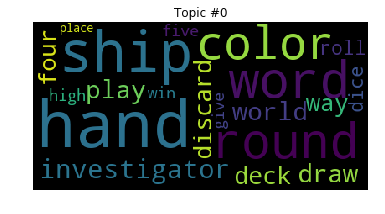

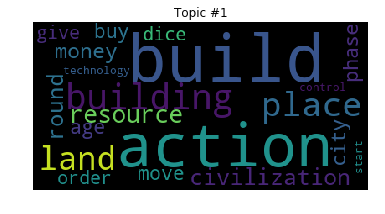

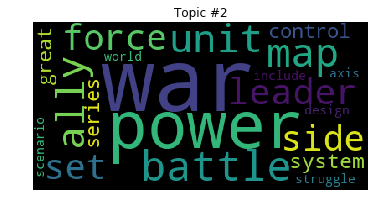

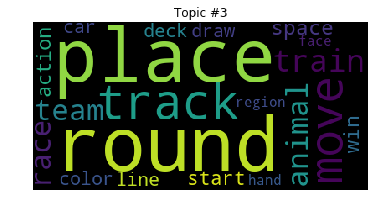

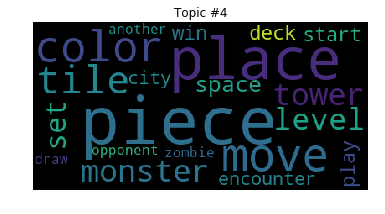

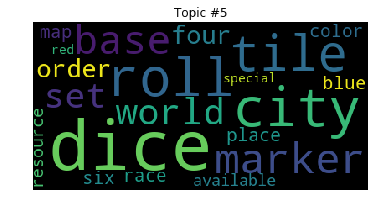

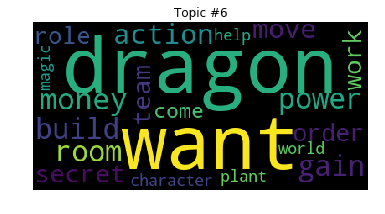

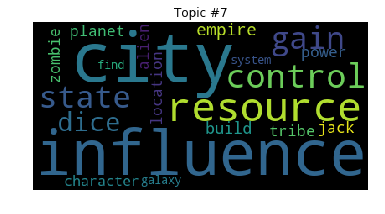

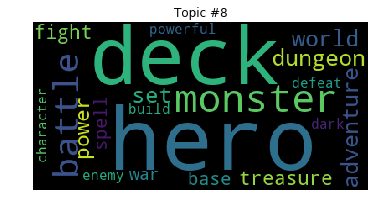

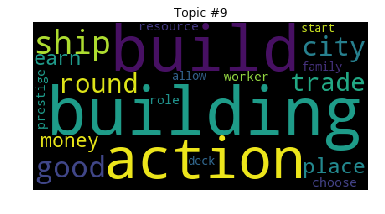

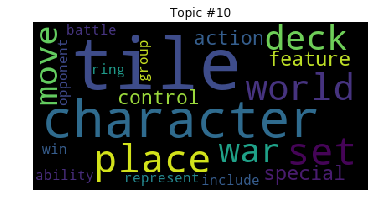

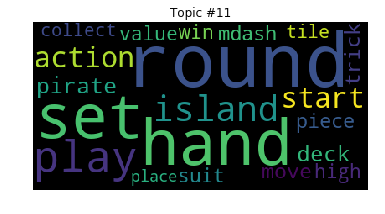

In [145]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for t in range(model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(model.show_topic(t, 20))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

Knowing the topic clusters is great and all, but its only useful if I can get the game names out of the model to determine similarity and make recommendation.  
The function get_game_in_groups gets a measure of the amount of each topic cluster in each document and finds the most prevalent topic for each document (the maximum). It then traces each document back to the original game title and prints out all the games in each topic cluster.  It also returns a df with the measure of each topic in each document, and a dataframe with each topic, and the games in it.  

In [181]:
df_model, df_check = get_game_in_groups(corpus, model, num_topics, test_df)

(u'King of Tokyo', u'Hanabi', u'Eldritch Horror', u'Elder Sign', u'Ghost Stories', u'Coloretto', u'UNO', u'BANG! The Dice Game', u'Shogun', u'T.I.M.E Stories', u'Dixit Odyssey', u"Liar's Dice", u'King of New York', u'Poker', u'Cranium', u'Mansions of Madness: Second Edition', u'Pit', u'Medici', u'The Great Dalmuti', u'Boggle', u'Port Royal', u'Bananagrams', u'Dice Town', u'Paperback', u'Dream Factory', u'Qwixx', u'Dominion: Dark Ages', u'Chez Geek', u'Tajemnicze Domostwo', u'Skip-Bo', u'Parade', u'CV', u'Vinhos', u'Arkham Horror: The King in Yellow Expansion', u'The Game', u'Dixit: Journey', u'Age of War', u'Core Worlds', u'Advanced Civilization', u'Arkham Horror: Innsmouth Horror Expansion', u'Arkham Horror: Kingsport Horror Expansion', u'Stockpile', u'Linko!', u'A Study in Emerald', u'Panamax', u'Elder Sign: Unseen Forces', u'Tempus', u'Money!', u"That's Life!", u'Quiddler', u'Ligretto', u'Galaxy Trucker: Anniversary Edition', u'Pok\xe9mon Trading Card Game', u'O Zoo le Mio', u'Eldri

In [182]:
df_model.head(3)

,name,description,tokens,tokens_w_bigrams,index1,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,max_group
0,Catan,"In Catan (formerly The Settlers of Catan), pla...","[formerly, settler, dominant, force, island, b...","[formerly, settler, dominant, force, island, b...",0,0.000219,0.071268,0.000226,0.000265,0.000238,0.926266,0.000194,0.000209,0.000302,0.000262,0.000285,0.000266,topic 5
1,Carcassonne,Carcassonne is a tile-placement game in which ...,"[tile, placement, draw, place, tile, piece, so...","[tile, placement, draw, place, tile, piece, so...",1,0.000511,0.000542,0.000530,0.000619,0.194285,0.000485,0.000454,0.000488,0.000706,0.359543,0.441216,0.000623,topic 10
2,Pandemic,"In Pandemic, several virulent diseases have br...","[several, virulent, disease, break, simultaneo...","[several, virulent, disease, break, simultaneo...",2,0.000438,0.000465,0.000454,0.000531,0.000478,0.739845,0.000389,0.000419,0.255349,0.000526,0.000571,0.000534,topic 5
3,Dominion,(from the back of the box:)&#10;&#10;&quot;You...,"[back, box, monarch, like, parent, ruler, plea...","[back, box, monarch, like, parent, ruler, plea...",3,0.000444,0.189442,0.398026,0.000537,0.000484,0.000421,0.000394,0.000424,0.000613,0.233510,0.000578,0.175127,topic 2
4,7 Wonders,You are the leader of one of the 7 great citie...,"[leader, great, city, ancient, world, gather, ...","[leader, great, city, ancient, world, gather, ...",4,0.000369,0.660337,0.000382,0.000446,0.000402,0.000350,0.000327,0.000352,0.000509,0.335596,0.000480,0.000449,topic 1
5,Ticket to Ride,"With elegantly simple gameplay, Ticket to Ride...","[elegantly, simple, gameplay, learn, minute, p...","[elegantly, simple, gameplay, learn, minute, p...",5,0.000396,0.000420,0.000411,0.950351,0.000432,0.045238,0.000352,0.000378,0.000548,0.000476,0.000516,0.000483,topic 3
6,Agricola,Description from BoardgameNews&#10;&#10;In Agr...,"[boardgamenews, agricola, farmer, wooden, shac...","[boardgamenews, agricola, farmer, wooden, shac...",6,0.000345,0.000365,0.000357,0.000417,0.000376,0.000327,0.000306,0.000329,0.000476,0.000414,0.000449,0.995839,topic 11
7,Puerto Rico,In Puerto Rico players assume the roles of col...,"[puerto, rico, assume, role, colonial, governo...","[puerto, rico, assume, role, colonial, governo...",7,0.000284,0.000301,0.000294,0.000344,0.000310,0.000270,0.000252,0.000271,0.000392,0.996567,0.000370,0.000346,topic 9
8,Small World,"In Small World, players vie for conquest and c...","[world, vie, conquest, control, world, simply,...","[world, vie, conquest, control, world, simply,...",8,0.000380,0.000403,0.000394,0.000460,0.000414,0.286959,0.000337,0.000363,0.057471,0.000456,0.651899,0.000463,topic 10
9,Power Grid,Power Grid is the updated release of the Fried...,"[power, grid, update, release, friedemann, fri...","[power, grid, update, release, friedemann, fri...",9,0.000388,0.000411,0.836906,0.000470,0.000423,0.000368,0.000344,0.000370,0.000536,0.158805,0.000505,0.000473,topic 2


In [183]:
df_check.head(12)

,max_group,name,index1
0,topic 0,"(King of Tokyo, Hanabi, Eldritch Horror, Elder...","(11, 30, 71, 80, 96, 100, 107, 159, 163, 166, ..."
1,topic 1,"(7 Wonders, 7 Wonders Duel, Monopoly, For Sale...","(4, 40, 49, 75, 79, 81, 85, 98, 112, 116, 121,..."
2,topic 10,"(Carcassonne, Small World, Risk, Coup, Eclipse...","(1, 8, 34, 38, 42, 44, 48, 67, 69, 73, 133, 13..."
3,topic 11,"(Agricola, Stone Age, Forbidden Island, Battle...","(6, 16, 24, 27, 31, 52, 64, 70, 74, 77, 83, 92..."
4,topic 2,"(Dominion, Power Grid, Twilight Struggle, Tigr...","(3, 9, 23, 45, 51, 63, 78, 88, 138, 149, 180, ..."
5,topic 3,"(Ticket to Ride, Ticket to Ride: Europe, Dixit...","(5, 13, 15, 18, 25, 39, 50, 56, 58, 82, 94, 97..."
6,topic 4,"(Munchkin, Hive, Blokus, Ingenious, Zombies!!!...","(21, 46, 68, 111, 117, 139, 140, 164, 172, 238..."
7,topic 5,"(Catan, Pandemic, Bohnanza, Pandemic Legacy: S...","(0, 2, 22, 65, 87, 115, 127, 182, 195, 227, 26..."
8,topic 6,"(Love Letter, Dead of Winter: A Crossroads Gam...","(12, 32, 114, 132, 147, 178, 179, 184, 197, 21..."
9,topic 7,"(Lords of Waterdeep, The Resistance, Android: ...","(20, 26, 41, 47, 54, 66, 84, 95, 123, 131, 134..."
